In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [2]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])
    
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


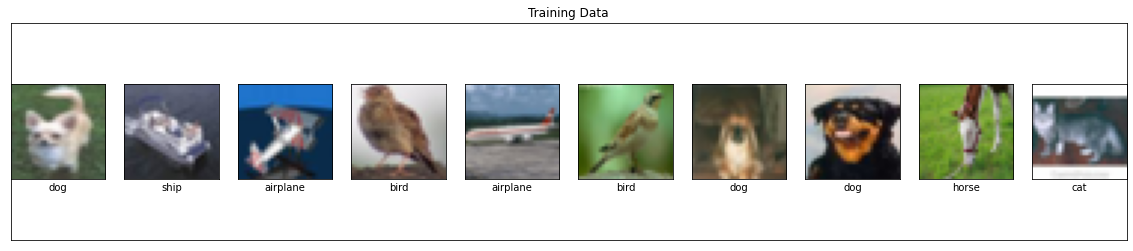

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )

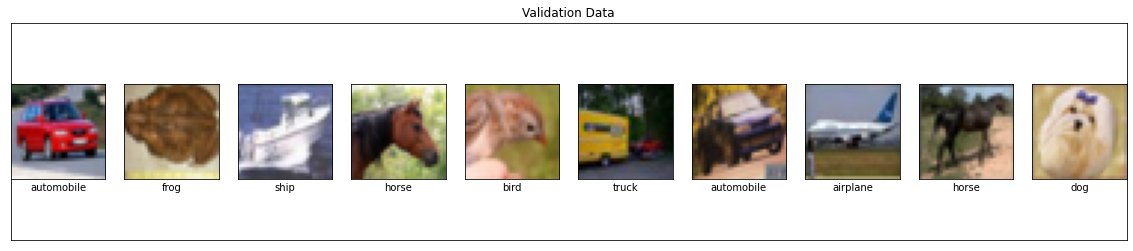

In [7]:
display_images(validation_images, validation_labels, validation_labels, "Validation Data" )

In [8]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [9]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [10]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [11]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

94773248/94765736 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
______________________________________________________________

In [12]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/4
  1/782 [..............................] - ETA: 6:45:59 - loss: 2.4846 - accuracy: 0.0781

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

In [ ]:
plot_metrics("loss", "Loss")

In [ ]:
plot_metrics("accuracy", "Accuracy")